In [57]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [2]:
seed = 42

In [3]:
train_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_image_paths.csv', header=None, names=['path'], dtype=str)
train_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)
valid_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_image_paths.csv', header=None, names=['path'], dtype=str)
valid_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)

In [4]:
train_image_paths_df['parent_path'] = train_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
train_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(train_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
train_merge = pd.merge(train_image_paths_df, train_labeled_studies_df, left_on='parent_path', right_on='path')
train_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
train_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = train_merge.pop('label')
train_merge.insert(train_merge.shape[1], 'label', label)

In [5]:
valid_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(valid_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
valid_image_paths_df['parent_path'] = valid_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
valid_merge = pd.merge(valid_image_paths_df, valid_labeled_studies_df, left_on='parent_path', right_on='path')
valid_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
valid_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = valid_merge.pop('label')
valid_merge.insert(valid_merge.shape[1], 'label', label)

In [12]:
train_merge['path'] = '/kaggle/input/mura-v11/' + train_merge['path']
valid_merge['path'] = '/kaggle/input/mura-v11/' + valid_merge['path']

In [13]:
train_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
1,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
2,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
3,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
4,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1


In [14]:
valid_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
1,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
2,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
3,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
4,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1


In [15]:
train = train_merge
valid, test = train_test_split(valid_merge, test_size=0.5, random_state=seed)

In [16]:
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,   
)

In [17]:
im_size = 256

In [18]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, x_col='path', y_col='label', class_mode='binary', batch_size=64, shuffle=True, target_size=(im_size, im_size), seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe=valid, x_col='path', y_col='label', class_mode='binary', batch_size=64, shuffle=True, target_size=(im_size, im_size), seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe=test, x_col='path', y_col='label', class_mode='binary', batch_size=64, shuffle=False, target_size=(im_size, im_size), seed=seed)

Found 36808 validated image filenames belonging to 2 classes.
Found 1598 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.


In [19]:
epochs = 20
input_shape=(im_size, im_size, 3)

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((input_shape)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.Dropout(rate=0.2),

    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),

    
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 128, 128, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 63, 63, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 63, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 31, 31, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 15, 15, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             

 Total params: 447,937 (1.71 MB)

 Trainable params: 446,977 (1.71 MB)

 Non-trainable params: 960 (3.75 KB)

In [22]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [25]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-07 07:56:47.513009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.67263, expected 2.11937
2024-04-07 07:56:47.513066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.74572, expected 3.19246
2024-04-07 07:56:47.513077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.22456, expected 3.6713
2024-04-07 07:56:47.513086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.49908, expected 3.94581
2024-04-07 07:56:47.513095: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

  2/576 ━━━━━━━━━━━━━━━━━━━━ 57s 99ms/step - binary_accuracy: 0.4492 - loss: 2.3474   

I0000 00:00:1712476623.404333      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/576 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - binary_accuracy: 0.5383 - loss: 1.3210

2024-04-07 08:08:44.293341: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.34226, expected 2.89031
2024-04-07 08:08:44.293410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 2.98646, expected 2.53451
2024-04-07 08:08:44.293452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7680: 3.44047, expected 2.98852
2024-04-07 08:08:44.293494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15871: 3.18368, expected 2.73174
2024-04-07 08:08:44.293512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18432: 2.94435, expected 2.4924
2024-04-07 08:08:44.293527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19711: 3.47596, expected 3.02401
2024-04-07 08:08:44.293588: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27136: 3.5094, expected 3.05746
2024-04-07 08:08:44.293622: E extern

576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.5412 - loss: 1.2431

2024-04-07 08:12:25.026870: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 2.75986, expected 1.96046
2024-04-07 08:12:25.026939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.02561, expected 3.22621
2024-04-07 08:12:25.026958: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.41235, expected 3.61295
2024-04-07 08:12:25.026989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 4.40374, expected 3.60434
2024-04-07 08:12:25.027002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 5.00467, expected 4.20527
2024-04-07 08:12:25.027012: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65541: 5.91006, expected 5.11066
2024-04-07 08:12:25.027022: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 4.9764, expected 4.177
2024-04-07 08:12:25.027034: E 

576/576 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - binary_accuracy: 0.5412 - loss: 1.2425 - val_binary_accuracy: 0.5757 - val_loss: 0.6860
Epoch 2/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - binary_accuracy: 0.5931 - loss: 0.6840 - val_binary_accuracy: 0.5369 - val_loss: 0.7312
Epoch 3/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - binary_accuracy: 0.6103 - loss: 0.6562 - val_binary_accuracy: 0.5426 - val_loss: 0.7022
Epoch 4/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - binary_accuracy: 0.6099 - loss: 0.6518 - val_binary_accuracy: 0.5294 - val_loss: 0.7908
Epoch 5/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - binary_accuracy: 0.6188 - loss: 0.6486 - val_binary_accuracy: 0.5325 - val_loss: 0.8002
Epoch 6/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - binary_accuracy: 0.6269 - loss: 0.6501 - val_binary_accuracy: 0.5839 - val_loss: 0.6760
Epoch 7/20
576/576 ━━━━━━━━━━━━━━━━━━━━ 668s 1s/step - binary_accuracy: 0.6336 - loss: 0.6360 - val_binary_accuracy: 0.5401 - val_loss: 1.1653
Epoch 8/20

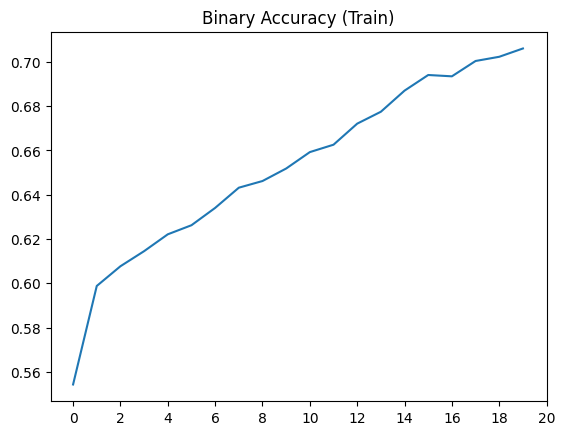

In [45]:
plt.plot(history.history['binary_accuracy'])
plt.xticks(range(0, epochs + 1, 2))
plt.title('Binary Accuracy (Train)')
plt.show()

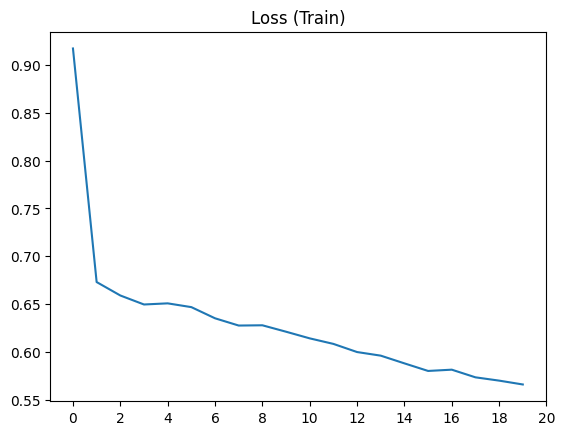

In [46]:
plt.plot(history.history['loss'])
plt.xticks(range(0, epochs + 1, 2))
plt.title('Loss (Train)')
plt.show()

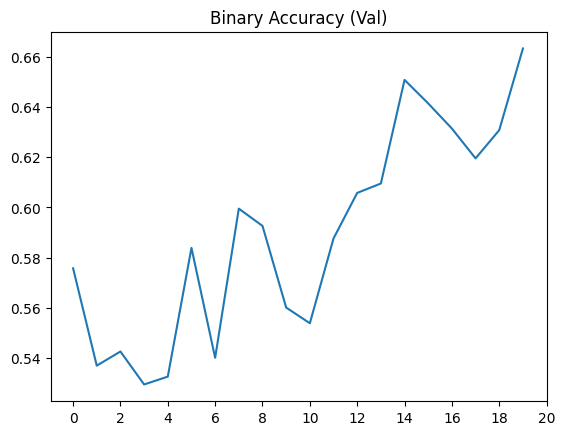

In [47]:
plt.plot(history.history['val_binary_accuracy'])
plt.xticks(range(0, epochs + 1, 2))
plt.title('Binary Accuracy (Val)')
plt.show()

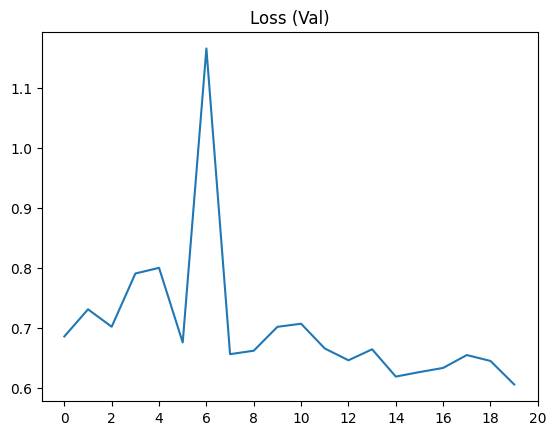

In [48]:
plt.plot(history.history['val_loss'])
plt.xticks(range(0, epochs + 1, 2))
plt.title('Loss (Val)')
plt.show()

In [44]:
evaluate_results = model.evaluate(test_generator)
evaluate_results

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - binary_accuracy: 0.6749 - loss: 0.5992


[0.5887477993965149, 0.6823014616966248]

In [49]:
model.save('cnn_model.keras')

In [63]:
print(classification_report(test_generator.labels, model.predict(test_generator).round()))

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
              precision    recall  f1-score   support

           0       0.65      0.84      0.74       830
           1       0.75      0.52      0.61       769

    accuracy                           0.69      1599
   macro avg       0.70      0.68      0.67      1599
weighted avg       0.70      0.69      0.68      1599

